### Problem 1: Sampling from the Prior

In this problem, we sample from the prior of a Gaussian Process. We first plot 

#### Kernels

In [0]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [0]:
matplotlib.rcParams['figure.figsize'] = [20,10]

In [0]:
def se_kernel(x1, x2, l=1.0):
  '''Squared exponential kernel'''
  return np.exp(-np.power(x1 - x2, 2) / (2 * l))

def mattern_kernel_3_2(x1, x2, l=1.0):
  '''Mattern kernel with v=3/2'''
  r = np.sqrt(np.power(x1 - x2, 2))
  return (1 + np.sqrt(3) * r / l ) * np.exp(-np.sqrt(3) * r / l)

def mattern_kernel_5_2(x1, x2, l=1.0):
  '''Mattern kernel with v=5/2'''
  r = np.sqrt(np.power(x1 - x2, 2))
  return (1 + np.sqrt(5) * r / l + (5*r*r)/(3*l*l) ) * np.exp(-np.sqrt(5) * r / l)

def k(x_vec_1, x_vec_2, kernel, length_scale=1.0):
  '''Returns covariance matrix K(x_vec), where x_vec is the input vector x'''
  mat = [[kernel(x1, x2, l=length_scale) for x2 in x_vec_1] for x1 in x_vec_2]
  return np.array(mat)

#### Sampling

In [0]:
# Uniform points in the interval [-5,5]
x_vec = np.arange(-5, 5, 0.05)

# Multiple length scales and kernels
lengths = [0.5, 1, 5]
kernels = [('SE', se_kernel), 
           ('Mattern (v=3/2)', mattern_kernel_3_2), 
           ('Mattern (v=5/2)', mattern_kernel_5_2),
           ('Mattern (v=inf)', se_kernel)]

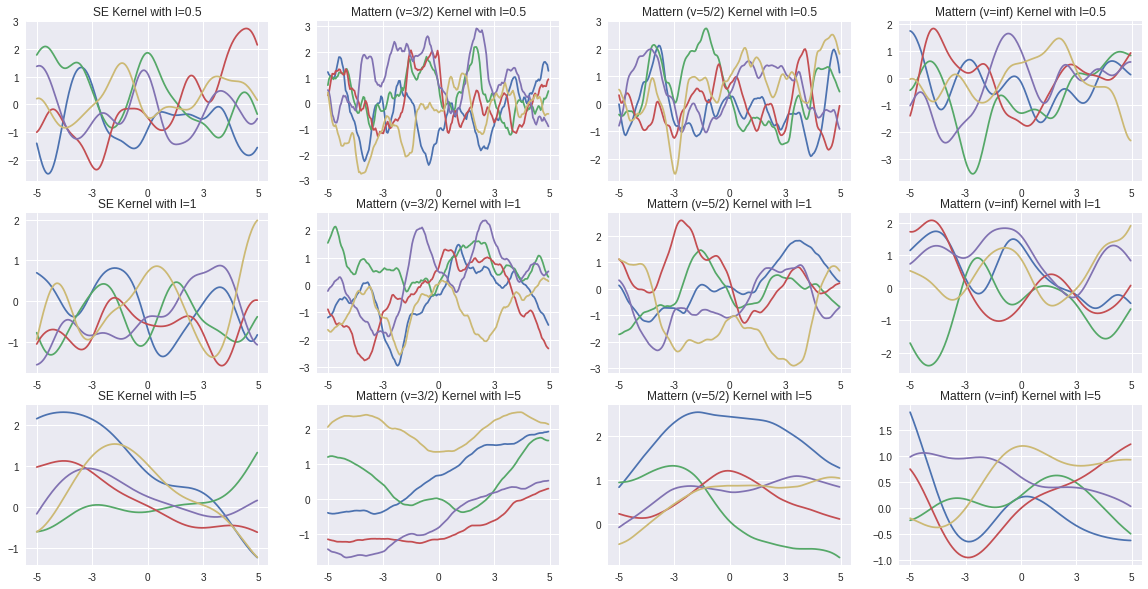

In [170]:
# Sample and plot
for j, l in enumerate(lengths):
  for h, (name, kernel) in enumerate(kernels):
    
    # Mean and covariance functions (on the points generate above)
    m_function = np.zeros(x_vec.shape)
    k_function = k(x_vec, x_vec, kernel, l)

    # 5 samples from Gaussian Process
    samples = []
    for i in range(0, 5):
      sample = np.random.multivariate_normal(m_function, k_function)
      samples.append(sample)

    plt.subplot(3,4,j*4+h+1)
    for s in samples:
      plt.gca().set_title(name + ' Kernel with l=' + str(l) )
      plt.gca().set_xticklabels([-5,-5,-3,0,3,5])
      plt.plot(s)
plt.show()

### Sampling from the Posterior

Using the analytical formula from Rasmussen and Williams, we compute the posterior.

In [0]:
# Data
X = np.array([-2.0,-1.8,-1.0,1,1.8,2]) 
y = - X*X*X*X + 3*X*X + 1

# Points on which to predict
S = np.arange(-5, 5, 0.05)

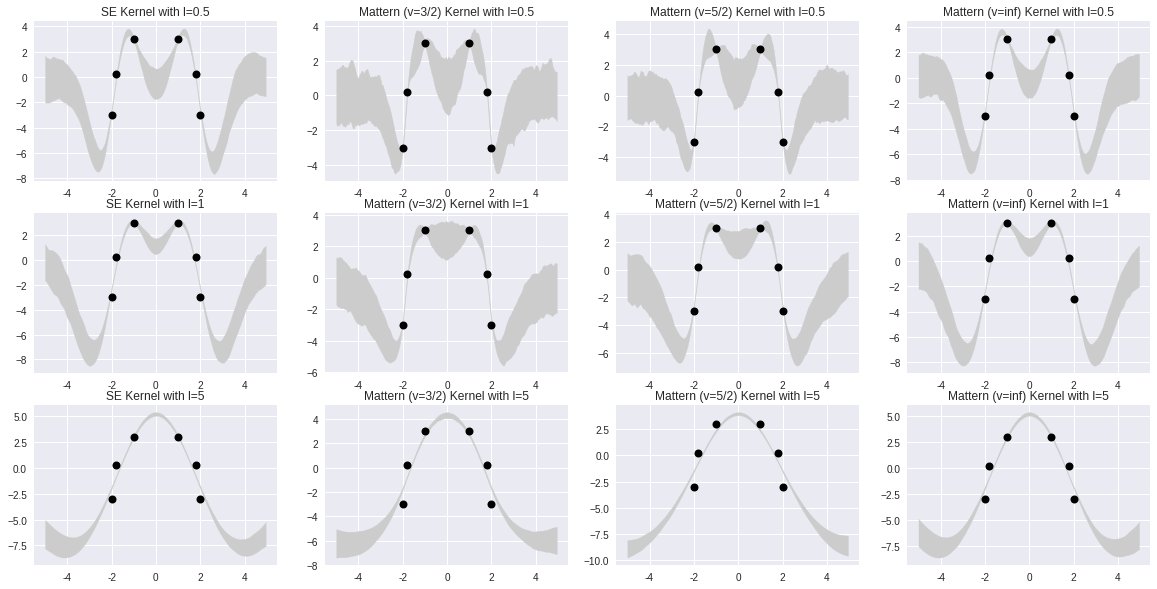

In [172]:
# Sample and plot
for j, l in enumerate(lengths):
  for h, (name, kernel) in enumerate(kernels):
    
    # Noise
    noise = np.eye(len(X)) * 0.01
    
    # Covariances
    K_xx = k(X, X, kernel, length_scale=l) + noise
    K_xs = k(X, S, kernel, length_scale=l)
    K_ss = k(S, S, kernel, length_scale=l)

    # Cholesky decomposition and solution
    L_dec = np.linalg.cholesky(K_xx + 1e-6*np.eye(len(X)))
    L_sol = np.linalg.solve(L_dec, K_xs.T)

    # Mean
    mu = np.dot(L_sol.T, np.linalg.solve(L_dec, y)).reshape(len(S),)
    
    # Calculate exact 95% confidence interval with standard deviation
    std = np.sqrt(np.diag(K_ss) - np.sum(np.power(L_sol, 2), axis=0))
    exact_ci = (mu - 2 * std, mu + 2 * std)

    # Calculate empirical 95% confidence interval by sampling from posterior
    L_sample = np.linalg.cholesky(K_ss + 1e-6*np.eye(len(S)) - np.dot(L_sol.T, L_sol))
    f_s = mu.reshape(-1,1) + np.dot(L_sample, np.random.normal(size=(len(S), 100)))
    f_s_95 = np.sort(f_s, axis=1)[:,5:-5]
    estim_ci = (f_s_95[:,0], f_s_95[:,-1])

    # Plot
    plt.subplot(3,4,j*4+h+1)    
    plt.gca().set_title(name + ' Kernel with l=' + str(l) )
    plt.plot(X, y, 'ks', ms=8, marker='o') # points 
    # Empirical confidence interval
    plt.gca().fill_between(S.flat, estim_ci[0], estim_ci[1], color="#cccccc")
    # # Exact confidence interval
    # plt.gca().fill_between(S.flat, mu-2*std, mu+2*std, color="#cccccc")
    plt.gca().set_xticklabels([-4,-4,-2,0,2,4]) # x-ticks
    
plt.show()